### Intsall Python and Grakel library

GraKeL is a library that provides implementations of several well-established graph kernels. 
The library unifies these kernels into a common framework.

* Note that Python version 3.10 may not be compatible with running the code below. Please install python 3.8.16 instead.

%pip install python==3.8.16

In [2]:
try:
    # Check if installed:
    import grakel
except ImportError:
    # If not installed, install it.
    %pip install python==3.8.16
    %pip install grakel==0.1.8

In [3]:
import itertools
import random
import time
from collections import defaultdict
from typing import Callable, Dict, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [4]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

In [5]:
def features_example(
    feature_extraction_fun: Callable[[nx.Graph], Dict[Union[str, Tuple[str, str]], Union[int, float]]],
    fig_size: Tuple[int, int] = (6, 3),
    node_color: str = "tab:orange",
    node_size: int = 1000,
    width: int = 2,
    seed: Optional[int] = None,
) -> None:
    edge_list = [("A", "C"), ("B", "C"), ("B", "D"), ("C", "D"), ("D", "E"), ("D", "H"), ("E", "F"), ("E", "G")]
    G = nx.Graph(edge_list)
    name = feature_extraction_fun.__name__.replace("_", " ").capitalize()
    features = feature_extraction_fun(G)
    pos = nx.spring_layout(G, seed=seed)

    plt.figure(figsize=fig_size)
    nx.draw(G, pos=pos, node_color=node_color, node_size=node_size, width=width, with_labels=True)
    plt.show()

    print(f"\n{name} values:")
    for key, value in sorted(features.items(), key=lambda item: item[0]):
        print(f"- {key}: {value:.2f}")

### 1. Node Features

#### 1.1. Node Degree

In [6]:
def node_degree(G: nx.Graph) -> Dict[str, int]:
    return dict(G.degree)

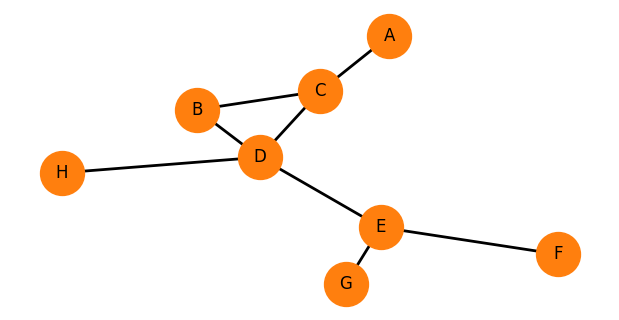


Node degree values:
- A: 1.00
- B: 2.00
- C: 3.00
- D: 4.00
- E: 3.00
- F: 1.00
- G: 1.00
- H: 1.00


In [7]:
features_example(node_degree, seed=42)

#### 1.2. Eigenvector centrality

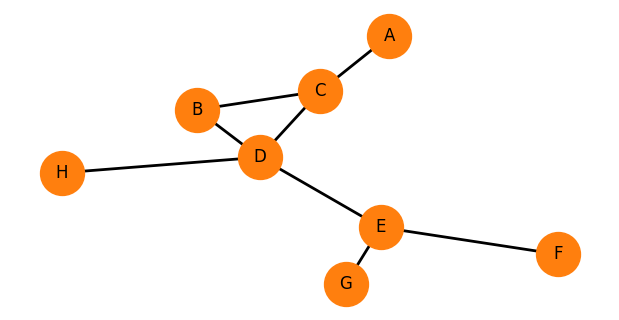


Eigenvector centrality values:
- A: 0.19
- B: 0.42
- C: 0.48
- D: 0.59
- E: 0.34
- F: 0.14
- G: 0.14
- H: 0.23


In [8]:
features_example(nx.eigenvector_centrality, seed=42)

#### 1.3. Betweenness centrality

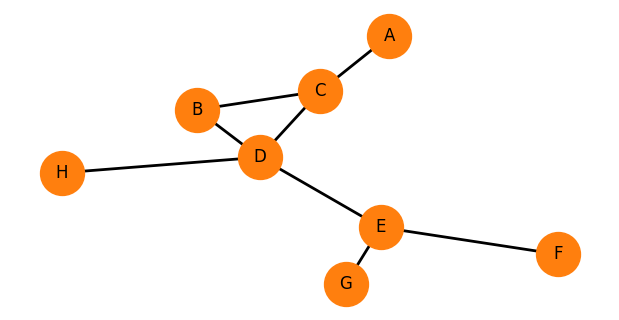


Betweenness centrality values:
- A: 0.00
- B: 0.00
- C: 0.29
- D: 0.71
- E: 0.52
- F: 0.00
- G: 0.00
- H: 0.00


In [9]:
features_example(nx.betweenness_centrality, seed=42)

#### 1.4. Closeness centrality

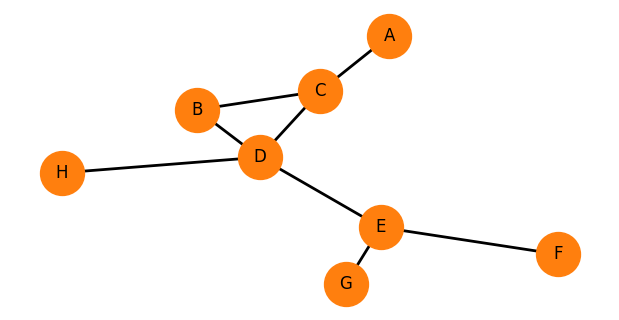


Closeness centrality values:
- A: 0.37
- B: 0.50
- C: 0.54
- D: 0.70
- E: 0.58
- F: 0.39
- G: 0.39
- H: 0.44


In [10]:
features_example(nx.closeness_centrality, seed=42)

#### 1.5. Clustering Coefficient

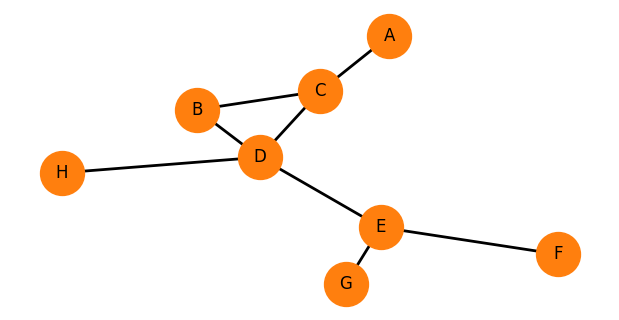


Clustering values:
- A: 0.00
- B: 1.00
- C: 0.33
- D: 0.17
- E: 0.00
- F: 0.00
- G: 0.00
- H: 0.00


In [11]:
features_example(nx.clustering, seed=42)

#### 1.6. Node features: Graphlets

In [12]:
def plot_graph(
    G: nx.Graph,
    root: str,
    graphlet_nodes: set = set(),
    node_size: int = 1000,
    width: int = 2,
    seed: Optional[int] = None,
) -> None:
    colors = {node: "tab:gray" for node in graphlet_nodes}
    colors[root] = "tab:red"
    node_color = [colors.get(node, "white") for node in G.nodes()]
    edgecolors = ["none" if node == root else "black" for node in G.nodes()]
    labels = {node: node if node == root else "" for node in G.nodes()}
    pos = nx.spring_layout(G, seed=seed)
    nx.draw(G, pos=pos, node_color=node_color, edgecolors=edgecolors, labels=labels, node_size=node_size, width=width)


def add_is_root_attr(G: nx.Graph, root: str) -> nx.Graph:
    is_root = {node: {"is_root": node == root} for node in G.nodes}
    nx.set_node_attributes(G, is_root)

## Possibile graphlets up to size 3

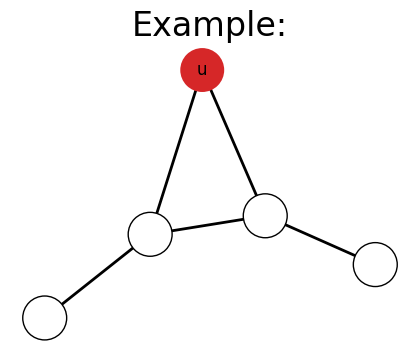

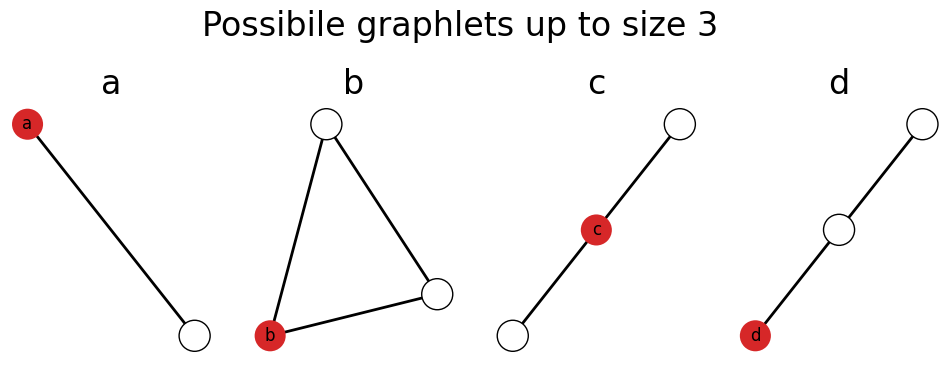

In [13]:
edge_list = [("u", "B"), ("u", "C"), ("B", "C"), ("B", "D"), ("C", "E")]
G = nx.Graph(edge_list)
add_is_root_attr(G, "u")
possible_graphlets_up_to_size_3 = {
    "a": nx.Graph([("a", "B")]),
    "b": nx.Graph([("b", "B"), ("b", "C"), ("B", "C")]),
    "c": nx.Graph([("c", "B"), ("c", "C")]),
    "d": nx.Graph([("B", "d"), ("B", "C")]),
}
for root, possible_graphlet in possible_graphlets_up_to_size_3.items():
    add_is_root_attr(possible_graphlet, root)


plt.figure(figsize=(4, 3))
plot_graph(G, "u")
plt.title("Example:", fontsize=24)
plt.show()

plt.figure(figsize=(12, 4))

for idx, (root, graphlet) in enumerate(possible_graphlets_up_to_size_3.items(), 1):
    plt.subplot(1, 4, idx)
    plt.title(root, fontsize=24)
    plot_graph(graphlet, root, node_size=500)

plt.suptitle("Possibile graphlets up to size 3", fontsize=24)
plt.subplots_adjust(top=0.75)
plt.show()

#### Graphlet instances of node u

In [14]:
def _node_match(n1: Dict[str, bool], n2: Dict[str, bool]) -> bool:
    return n1["is_root"] and n2["is_root"] or not n1["is_root"] and not n2["is_root"]


def get_graphlet_instances(
    G: nx.Graph, node: str, possible_graphlets: Dict[str, nx.Graph], max_size: int = 3
) -> Dict[str, List[nx.Graph]]:
    graphlet_instances = defaultdict(list)
    for size in range(2, max_size + 1):
        for combination in itertools.combinations(G.nodes, size):
            if node in combination:
                subgraph = nx.subgraph(G, combination)
                if nx.is_connected(subgraph):
                    for key, graphlet in possible_graphlets.items():
                        if nx.is_isomorphic(subgraph, graphlet, node_match=_node_match):
                            graphlet_instances[key].append(subgraph)
                            break

    return dict(graphlet_instances)

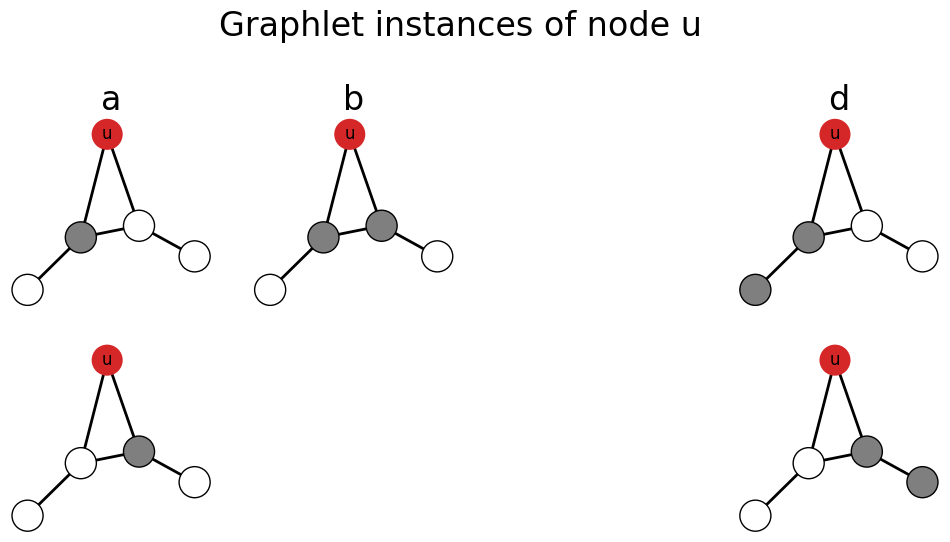

In [15]:
graphlet_instances = get_graphlet_instances(G, "u", possible_graphlets_up_to_size_3)
num_rows = max(len(graphlets) for graphlets in graphlet_instances.values())
num_cols = len(possible_graphlets_up_to_size_3)

plt.figure(figsize=(12, 6))
for col_idx, key in enumerate(sorted(possible_graphlets_up_to_size_3.keys())):
    graphlets = graphlet_instances.get(key, {})
    for row_idx, graphlet in enumerate(graphlets):
        plt.subplot(num_rows, num_cols, row_idx * num_cols + col_idx + 1)
        plot_graph(G, "u", graphlet.nodes, node_size=500, seed=42)
        if row_idx == 0:
            plt.title(key, fontsize=24)

plt.suptitle("Graphlet instances of node u", fontsize=24)
plt.subplots_adjust(top=0.80)
plt.show()

#### Graph Degree Vector (GDV) of node u

In [16]:
def get_graph_degree_vector(G: nx.Graph, root: str, possible_graphlets: Dict[str, nx.Graph]) -> List[int]:
    graphlet_instances = get_graphlet_instances(G, "u", possible_graphlets)
    out = []
    for key in sorted(possible_graphlets.keys()):
        out.append(len(graphlet_instances.get(key, [])))

    return out

In [17]:
gdv = get_graph_degree_vector(G, "u", possible_graphlets_up_to_size_3)

print(f"GDV of a node u: {gdv}")

GDV of a node u: [2, 1, 0, 2]


## 2. Link-Level Features: Overview

#### 2.1. Shortest-path distance between two nodes

In [18]:
def shortest_path_length(G: nx.Graph) -> Dict[Tuple[str, str], int]:
    out = {}
    for node_pair in itertools.combinations(G.nodes, 2):
        out[node_pair] = nx.shortest_path_length(G, *node_pair)

    return out

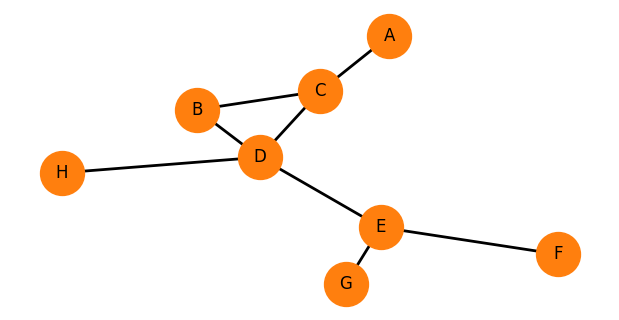


Shortest path length values:
- ('A', 'B'): 2.00
- ('A', 'C'): 1.00
- ('A', 'D'): 2.00
- ('A', 'E'): 3.00
- ('A', 'F'): 4.00
- ('A', 'G'): 4.00
- ('A', 'H'): 3.00
- ('B', 'D'): 1.00
- ('B', 'E'): 2.00
- ('B', 'F'): 3.00
- ('B', 'G'): 3.00
- ('B', 'H'): 2.00
- ('C', 'B'): 1.00
- ('C', 'D'): 1.00
- ('C', 'E'): 2.00
- ('C', 'F'): 3.00
- ('C', 'G'): 3.00
- ('C', 'H'): 2.00
- ('D', 'E'): 1.00
- ('D', 'F'): 2.00
- ('D', 'G'): 2.00
- ('D', 'H'): 1.00
- ('E', 'F'): 1.00
- ('E', 'G'): 1.00
- ('E', 'H'): 2.00
- ('F', 'G'): 2.00
- ('H', 'F'): 3.00
- ('H', 'G'): 3.00


In [19]:
features_example(shortest_path_length, seed=42)

#### 2.2. Local Neighborhood Overlap

#### Common neighbors

In [20]:
def num_common_neighbors(G: nx.Graph) -> Dict[Tuple[str, str], int]:
    return {edge: len(list((nx.common_neighbors(G, *edge)))) for edge in itertools.combinations(G.nodes, 2)}

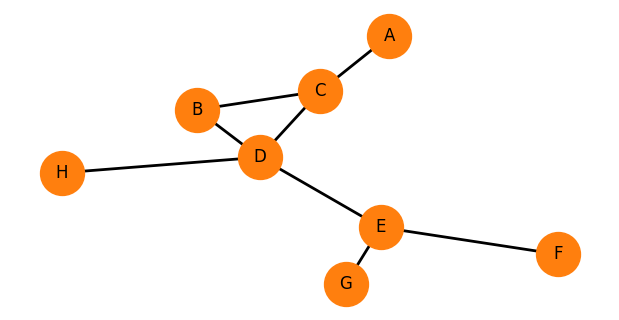


Num common neighbors values:
- ('A', 'B'): 1.00
- ('A', 'C'): 0.00
- ('A', 'D'): 1.00
- ('A', 'E'): 0.00
- ('A', 'F'): 0.00
- ('A', 'G'): 0.00
- ('A', 'H'): 0.00
- ('B', 'D'): 1.00
- ('B', 'E'): 1.00
- ('B', 'F'): 0.00
- ('B', 'G'): 0.00
- ('B', 'H'): 1.00
- ('C', 'B'): 1.00
- ('C', 'D'): 1.00
- ('C', 'E'): 1.00
- ('C', 'F'): 0.00
- ('C', 'G'): 0.00
- ('C', 'H'): 1.00
- ('D', 'E'): 0.00
- ('D', 'F'): 1.00
- ('D', 'G'): 1.00
- ('D', 'H'): 0.00
- ('E', 'F'): 0.00
- ('E', 'G'): 0.00
- ('E', 'H'): 1.00
- ('F', 'G'): 1.00
- ('H', 'F'): 0.00
- ('H', 'G'): 0.00


In [21]:
features_example(num_common_neighbors, seed=42)

#### Jaccard's coefficient

In [22]:
def jaccard_coefficient(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    out = {}
    for item in nx.jaccard_coefficient(G, itertools.combinations(G.nodes, 2)):
        out[(item[:2])] = item[2]

    return out

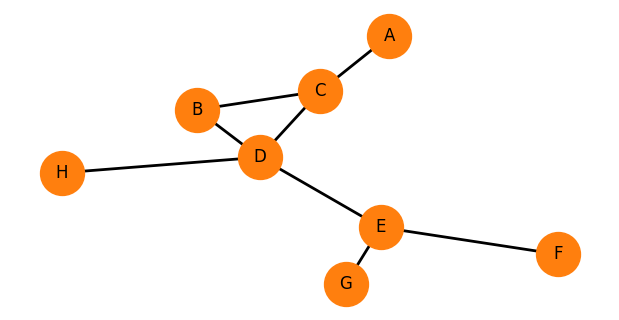


Jaccard coefficient values:
- ('A', 'B'): 0.50
- ('A', 'C'): 0.00
- ('A', 'D'): 0.25
- ('A', 'E'): 0.00
- ('A', 'F'): 0.00
- ('A', 'G'): 0.00
- ('A', 'H'): 0.00
- ('B', 'D'): 0.20
- ('B', 'E'): 0.25
- ('B', 'F'): 0.00
- ('B', 'G'): 0.00
- ('B', 'H'): 0.50
- ('C', 'B'): 0.25
- ('C', 'D'): 0.17
- ('C', 'E'): 0.20
- ('C', 'F'): 0.00
- ('C', 'G'): 0.00
- ('C', 'H'): 0.33
- ('D', 'E'): 0.00
- ('D', 'F'): 0.25
- ('D', 'G'): 0.25
- ('D', 'H'): 0.00
- ('E', 'F'): 0.00
- ('E', 'G'): 0.00
- ('E', 'H'): 0.33
- ('F', 'G'): 1.00
- ('H', 'F'): 0.00
- ('H', 'G'): 0.00


In [23]:
features_example(jaccard_coefficient, seed=42)

#### Adamic-Adar index

In [24]:
def adamic_adar_index(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    out = {}
    for item in nx.adamic_adar_index(G, itertools.combinations(G.nodes, 2)):
        out[(item[:2])] = item[2]

    return out

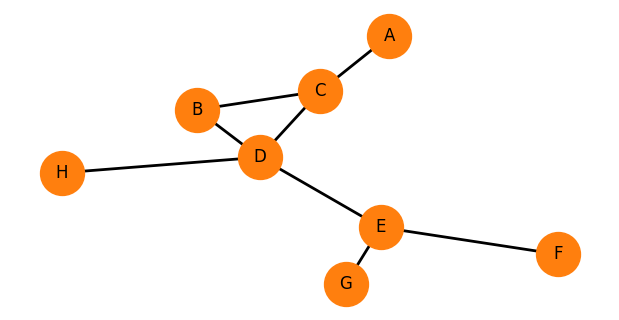


Adamic adar index values:
- ('A', 'B'): 0.91
- ('A', 'C'): 0.00
- ('A', 'D'): 0.91
- ('A', 'E'): 0.00
- ('A', 'F'): 0.00
- ('A', 'G'): 0.00
- ('A', 'H'): 0.00
- ('B', 'D'): 0.91
- ('B', 'E'): 0.72
- ('B', 'F'): 0.00
- ('B', 'G'): 0.00
- ('B', 'H'): 0.72
- ('C', 'B'): 0.72
- ('C', 'D'): 1.44
- ('C', 'E'): 0.72
- ('C', 'F'): 0.00
- ('C', 'G'): 0.00
- ('C', 'H'): 0.72
- ('D', 'E'): 0.00
- ('D', 'F'): 0.91
- ('D', 'G'): 0.91
- ('D', 'H'): 0.00
- ('E', 'F'): 0.00
- ('E', 'G'): 0.00
- ('E', 'H'): 0.72
- ('F', 'G'): 0.91
- ('H', 'F'): 0.00
- ('H', 'G'): 0.00


In [25]:
features_example(adamic_adar_index, seed=42)

#### 2.3. Global Neighborhood Overlap

In [26]:
def get_katz_index_matrix(G: nx.Graph, beta: float) -> np.ndarray:
    A = nx.adjacency_matrix(G).todense()
    X = beta * A
    max_eigval = np.linalg.eigvals(X).max()
    if max_eigval >= 1.0:
        raise ValueError(
            "to apply the geometric series of matrices, the maximum eigenvalue of beta * A must be < 1, got "
            f"{max_eigval}"
        )

    I = np.eye(X.shape[0])
    S = np.linalg.inv(I - X) - I
    return S


def katz_index_beta_03(G: nx.Graph) -> Dict[Tuple[str, str], float]:
    S = get_katz_index_matrix(G, 0.3)
    nodes = list(G.nodes)
    ki = {}
    for node_pair in itertools.combinations(G.nodes, 2):
        row_idx = nodes.index(node_pair[0])
        col_idx = nodes.index(node_pair[1])
        ki[node_pair] = S[row_idx, col_idx]

    return ki


katz_index_beta_03.__name__ = "katz_index_(beta=0.3)"

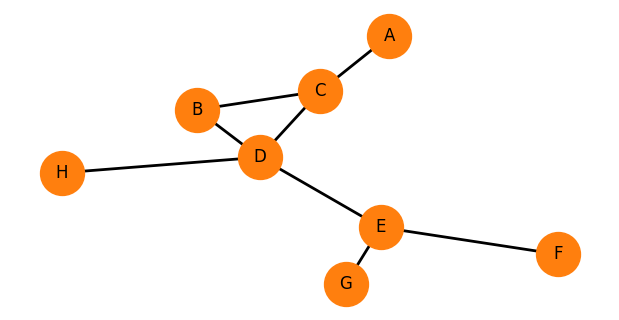


Katz index (beta=0.3) values:
- ('A', 'B'): 0.23
- ('A', 'C'): 0.50
- ('A', 'D'): 0.27
- ('A', 'E'): 0.10
- ('A', 'F'): 0.03
- ('A', 'G'): 0.03
- ('A', 'H'): 0.08
- ('B', 'D'): 0.84
- ('B', 'E'): 0.31
- ('B', 'F'): 0.09
- ('B', 'G'): 0.09
- ('B', 'H'): 0.25
- ('C', 'B'): 0.77
- ('C', 'D'): 0.91
- ('C', 'E'): 0.33
- ('C', 'F'): 0.10
- ('C', 'G'): 0.10
- ('C', 'H'): 0.27
- ('D', 'E'): 0.70
- ('D', 'F'): 0.21
- ('D', 'G'): 0.21
- ('D', 'H'): 0.57
- ('E', 'F'): 0.44
- ('E', 'G'): 0.44
- ('E', 'H'): 0.21
- ('F', 'G'): 0.13
- ('H', 'F'): 0.06
- ('H', 'G'): 0.06


In [27]:
features_example(katz_index_beta_03, seed=42)

### 3. Graph-Level Features: Overview

In [28]:
import grakel
from grakel.kernels import GraphletSampling, WeisfeilerLehman
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

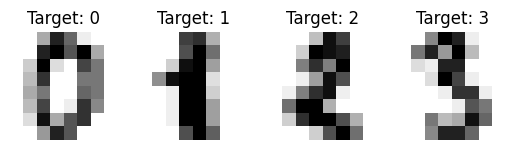

In [29]:
digits = load_digits()
images = digits.images
y = digits.target

for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.title(f"Target: {y[i]}")
    plt.axis("off")

In [30]:
def images_to_graphs(images: np.ndarray) -> List[grakel.Graph]:
    num_images, height, width = images.shape
    graphs = []
    edges = []
    edge_labels = {}
    for row_idx in range(height):
        for col_idx in range(width):
            if col_idx < width - 1:
                edge = (row_idx * height + col_idx, row_idx * height + col_idx + 1)
                edges.append(edge)
                edge_labels[edge] = 1

            if row_idx < height - 1:
                edge = (row_idx * height + col_idx, (row_idx + 1) * height + col_idx)
                edges.append(edge)
                edge_labels[edge] = 2

    for image_idx in range(num_images):
        node_labels = dict()
        for row_idx in range(height):
            for col_idx in range(width):
                node_labels[row_idx * height + col_idx] = int(images[image_idx, row_idx, col_idx] / 4)

        graphs.append(grakel.Graph(edges, node_labels=node_labels, edge_labels=edge_labels))

    return graphs

In [31]:
graphs = images_to_graphs(images)

print("Splitting dataset into train/test (1000/100 instances)")
graphs_train, graphs_test = graphs[:1000], graphs[1000:1100]
y_train, y_test = y[:1000], y[1000:1100]

Splitting dataset into train/test (1000/100 instances)


#### 3.1. Graphlet Kernel

In [32]:
start_time = time.perf_counter()

gk = GraphletSampling(k=3)
K_train = gk.fit_transform(graphs_train)
K_test = gk.transform(graphs_test)

clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)

y_pred = clf.predict(K_test)

print(f"Classification accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Duration: {time.perf_counter() - start_time:.2f} s")

Classification accuracy: 0.09
Duration: 14.43 s


#### 3.2. Weisfeiler-Lehman Kernel

In [33]:
start_time = time.perf_counter()

gk = WeisfeilerLehman(n_iter=5)
K_train = gk.fit_transform(graphs_train)
K_test = gk.transform(graphs_test)

clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)

y_pred = clf.predict(K_test)

print(f"Classification accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Duration: {time.perf_counter() - start_time:.2f} s")

Classification accuracy: 0.83
Duration: 0.87 s
